# Testing EOF decomposition with dask using `xeofs` package

When running the main notebook workflow, different results are obtained when loading the sst data array into memory as a numpy array before doing comps, vs leaving the sst as a dask array. The dask array results look off. This notebook investigates where the deviation is occurring.

In [1]:
## Need latest versions (as of October 2023) of all the below packages to ensure this notebook works

import earthaccess

import xarray as xr
import numpy as np
import xeofs as xe
from eofs.standard import Eof

import matplotlib.pyplot as plt
from cartopy.crs import EqualEarth, PlateCarree

import coiled

%matplotlib inline

In [24]:
sst = xr.tutorial.open_dataset('ersstv5')['sst']
sst

<xarray.DataArray 'sst' (time: 624, lat: 89, lon: 180)>
[9996480 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [25]:
from dask.array import from_array

In [26]:
model_np = xe.models.EOF(n_modes=5, standardize=False)
model_np.fit(sst, dim='time')
expvar_np = model.explained_variance_ratio()
components_np = model.components()
scores_np = model.scores()

In [32]:
sst_da = sst.copy()
sst_da.data = from_array(sst.data, chunks=(100, 20, 20))

In [33]:
sst_da

<xarray.DataArray 'sst' (time: 624, lat: 89, lon: 180)>
dask.array<array, shape=(624, 89, 180), dtype=float32, chunksize=(100, 20, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1970-01-01 1970-02-01 ... 2021-12-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [37]:
model_da = xe.models.EOF(n_modes=5, standardize=False)
model_da.fit(sst_da, dim='time')
expvar_da = model_da.explained_variance_ratio().compute()
components_da = model_da.components().compute()
scores_da = model_da.scores().compute()

In [39]:
print("explained variances (numpy version): " + str(expvar_np.data))
print("explained variances (dask version): " + str(expvar_da.data))

explained variances (numpy version): [0.8552536  0.03236326 0.02734844 0.01215133 0.00929785]
explained variances (dask version): [0.8525061  0.02863982 0.02445062 0.01022448 0.00683091]


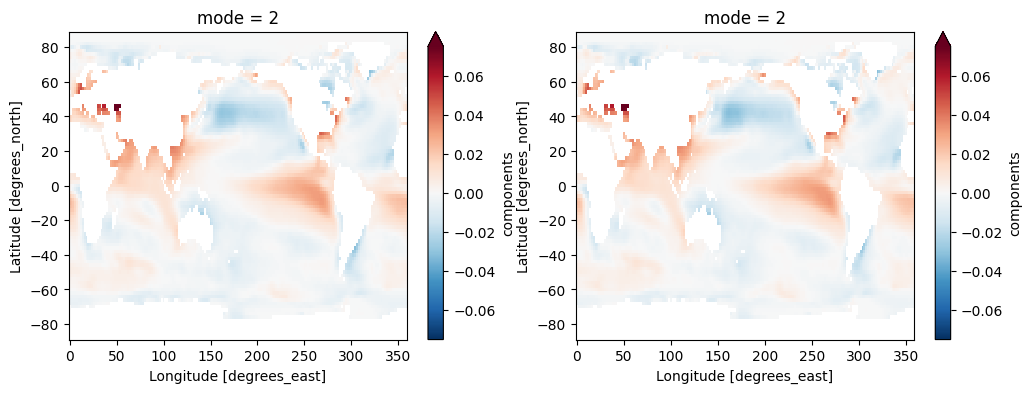

In [49]:
fig1, axes1 = plt.subplots(1, 2, figsize=(12,4))
components_np.sel(mode=2).plot(ax=axes1[0], vmin=-0.075, vmax=0.075, cmap='RdBu_r')
components_da.sel(mode=2).plot(ax=axes1[1], vmin=-0.075, vmax=0.075, cmap='RdBu_r')

# 1. Locate file endpoints and load data with `Xarray`

## 1.1 Locate endpoints
The `earthaccess` package is used to login to Earthdata and locate endpoints for all needed data files. The endpoints will be used with `Xarray` to access the data without downloading.

In [50]:
earthaccess.login() # Login with your credentials

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
No .netrc found in /home/mambauser


Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
earthaccess generated a token for CMR with expiration on: 12/23/2023
earthaccess generated a token for CMR with expiration on: 12/23/2023
Using user provided credentials for EDL


In [51]:
%%time

# Locate endpoints:
endpoints = earthaccess.search_data(
    short_name="REYNOLDS_NCDC_L4_MONTHLY_V5",
    cloud_hosted=True,
    temporal=("1910-01-01", "2008-02-01"), # We only want till end of 2007, but this ending date was required to obtain that.
    )

Granules found: 1178
CPU times: user 153 ms, sys: 3.98 ms, total: 157 ms
Wall time: 22.3 s


In [52]:
# Generate file objects from the endpoints which are compatible with Xarray:
fileobjs = earthaccess.open(endpoints[1:]) # The month prior to 1910-01-01 is included in the returned endpoints (bug?), so start the list at the 2nd element.

 Opening 1177 granules, approx size: 0.12 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1177 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1177 [00:00<?, ?it/s]

**Removal of one of the file objects which returned a bad result**

These lines of code are not typically needed for other datasets, but for some reason earthaccess returns one endpoint for a file which does not exist. Remove this element from the file objects list:

In [53]:
# Print the bad result just for reference:
fileobjs_bad = [f for f in fileobjs if type(f) == FileNotFoundError]
print(fileobjs_bad)

# Remove this bad result from the list:
fileobjs = [f for f in fileobjs if type(f) != FileNotFoundError]

[FileNotFoundError('podaac-ops-cumulus-protected/REYNOLDS_NCDC_L4_MONTHLY_V5/ersst.v5.195908.nc.1')]


## 1.2 Load data

If working in the cloud, loading and combining all files for this analysis into a single dataset object will take 2-4 minutes. This can be sped up using e.g. `kerchunk` or parallelization with remote clusters, but to simplify this notebook those methods are not implemented.

In [54]:
%%time

# The runtime of this line can be decreased using parallelization:
sstdata = xr.open_mfdataset(fileobjs, chunks={})
sstdata = sstdata.squeeze() # Remove the unnecessary 'lev' dimension (size 1)
sstdata

CPU times: user 38.9 s, sys: 539 ms, total: 39.4 s
Wall time: 4min 9s


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 1176)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1910-01-01 00:00:00 ... 2007-12-01 00:00:00
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
    ssta     (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.191001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

In [12]:
# Test to see if discrepancies between this analysis and the non-dask-array analysis is due to dask or due to something I'm doing:
#sstdata = sstdata.load()

# 2. Detrend and Remove Seasonal Cycle

As in the publication, we remove the long term linear trend and the seasonal cycle from the timeseries, since we are interested in other modes of variablility.

**Future updates**
* Try using Xarray's version of Polyfit: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.polyfit.html
* Try using Xarray's groupby to compute mean seasonal cycle: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html

In [55]:
def preprocess(sst):

    # Remove long-term linear trend:
    p = sst.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
    fit = xr.polyval(sst['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
    sst_detrend = (sst - fit) # xarray is smart enough to subtract along the time dim only.

    # Remove seasonal cycle:
    seasonal_cycle = sst_detrend.groupby("time.month").mean("time")
    sst_nocycle = sst_detrend.groupby("time.month") - seasonal_cycle

    return sst_nocycle

In [56]:
sst_da = sstdata['sst']

In [66]:
sst_np = sstdata['sst'].compute()

In [67]:
sst_prepro_np = preprocess(sst_np)

In [61]:
sst_prepro_da = preprocess(sst_da).compute()

/opt/coiled/env/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 98 times more chunks
  return self.array[key]


In [ ]:
sst_prepro_np = sst_prepro_np.values.flatten()

In [84]:
sst_prepro_np = sst_prepro_np[np.isfinite(sst_prepro_np)]

In [85]:
sst_prepro_da = sst_prepro_da.values.flatten()

In [86]:
sst_prepro_da = sst_prepro_da[np.isfinite(sst_prepro_da)]

In [87]:
len(sst_prepro_da)

12921888

In [88]:
len(sst_prepro_np)

12921888

In [13]:
# Remove data poleward of 65 degress lat (copying the publication):
sstdata = sstdata.sel(lat=slice(-65, 65))

### 2.1 Linear Detrend

In [14]:
sst_detrend = sstdata['sst']

Compute and remove linear trend

In [15]:
# Nothing actually computed fully in this block:
p = sst_detrend.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst_detrend['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst_detrend - fit) # xarray is smart enough to subtract along the time dim only.

Test plot of detrend results at a few locations on the globe

In [17]:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")
sst_nocycle = sst_detrend.groupby("time.month") - seasonal_cycle

In [22]:
sst_nocycle = sst_nocycle.where(sstvar < 2, drop=False) # Remove the few points with anomolously high variances.

## 3. EOF decomp

**Fit the model**

In [23]:
wgts = np.cos(np.deg2rad(sst_nocycle['lat']))**0.5 # Common practice to weight by latitude

In [24]:
%%time

model = xe.models.EOF(
    n_modes=6,
    use_weights=True,
    standardize=False
    )
model.fit(sst_nocycle, dim='time', weights=wgts)

CPU times: user 516 ms, sys: 96.2 ms, total: 612 ms
Wall time: 612 ms


**Compute PCAs (scores), EOFs (components), and explained variances**

In [25]:
%%time

expvar = model.explained_variance_ratio().compute()
expvar.values

CPU times: user 673 µs, sys: 14 µs, total: 687 µs
Wall time: 695 µs


array([0.15566093, 0.04830667, 0.03850468, 0.03468481, 0.03283799,
       0.02759277])

In [26]:
%%time

# The package automatically normalizes the returned PCA's ("scores"). We back out the raw scores here:
scores = model.scores().compute()
svals = model.singular_values().compute()
scores_raw = scores * svals

CPU times: user 1.76 ms, sys: 0 ns, total: 1.76 ms
Wall time: 1.72 ms


In [27]:
%%time

# EOFs ("components"):
components = model.components().compute()

CPU times: user 2.82 ms, sys: 0 ns, total: 2.82 ms
Wall time: 2.39 ms


**Plot EOFs and PCA's**

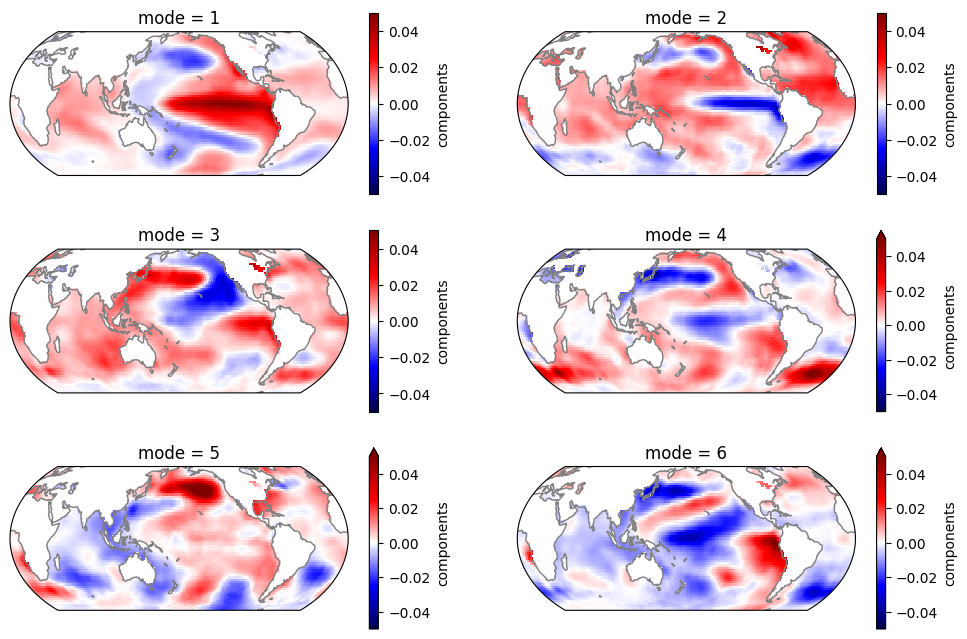

In [28]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    #'cmap' : 'RdBu', 'transform': PlateCarree()
    'cmap' : 'seismic', 'transform': PlateCarree()
}

fig4 = plt.figure(figsize=(12, 8))

axes4 = []
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))

for ax in axes4:
    ax.coastlines(color='.5')
    
for i, ax in zip(range(1,7), axes4):
    components.sel(mode=i).plot(ax=ax, vmin=-0.05, vmax=0.05, **kwargs)
    #components.sel(mode=i).plot(ax=ax, vmin=-2, vmax=2, **kwargs)
    #components.sel(mode=i).plot(ax=ax, **kwargs)

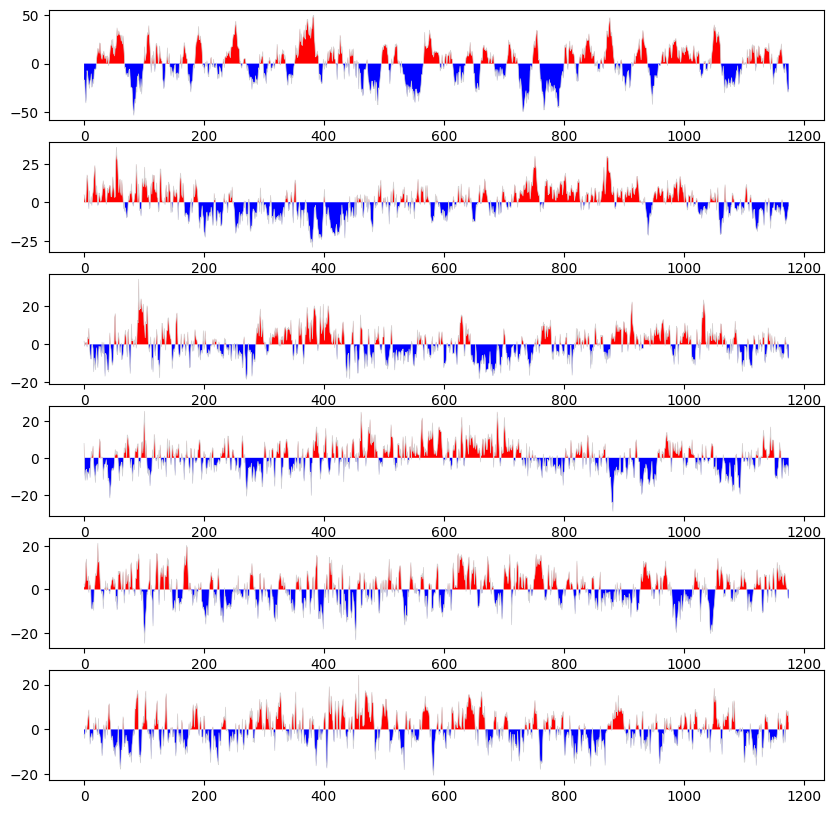

In [150]:
fig5, axes5 = plt.subplots(6, 1, figsize=(10,10))

x = range(len(scores['time']))
zeroline = np.zeros(len(x))

for i, ax in zip(range(1, 7), axes5):
    scores_raw_i = scores_raw.sel(mode=i).values
    pos_score = scores_raw_i > 0
    ax.fill_between(x, scores_raw_i, zeroline, where=pos_score, facecolor='red', interpolate=True)
    ax.fill_between(x, scores_raw_i, zeroline, where=~pos_score, facecolor='blue', interpolate=True)
    ax.plot(scores_raw_i, color='lightgrey', linewidth=0.5)
    #ax.set_ylim(-1, 1)